# Demo of HiDDeN pre-trained on CIFAR10 dataset

In [1]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from torchvision import transforms

from hidden.models import HiddenEncoder, HiddenDecoder, EncoderWithJND
from hidden.models.attenuations import JND
from hidden.ops.transforms import Normalize, Denormalize

C:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Build models and load weights

The watermark signal can be rescaled with a factor `scaling_w`.

We use the just noticeable difference (JND) heatmap presented in https://github.com/facebookresearch/active_indexing to mask the watermark signal in areas where the eye is sensitive to changes.
This allows to impose perceptual constraint, in case we want to use the trained encoder to watermark images.

In [2]:
from argparse import Namespace

NORMALIZE_IMAGENET = Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
DENORMALIZE_IMAGENET = Denormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
default_transform = transforms.Compose([transforms.ToTensor(), NORMALIZE_IMAGENET])

params = Namespace(
    img_channels=3, num_bits=48,
    encoder_depth=4, encoder_channels=64, decoder_depth=8, decoder_channels=64,
    attenuation='none', scale_channels=False, scaling_i=1.0, scaling_w=0.3,
    device='cuda'
)
params.device = torch.device(params.device)

decoder = HiddenDecoder(
    num_blocks=params.decoder_depth,
    num_bits=params.num_bits,
    channels=params.decoder_channels,
    in_channels=params.img_channels,
)
encoder = HiddenEncoder(
    num_blocks=params.encoder_depth,
    num_bits=params.num_bits,
    channels=params.encoder_channels,
    in_channels=params.img_channels,
)
attenuation = JND(preprocess=DENORMALIZE_IMAGENET) if params.attenuation == 'jnd' else None
encoder_with_jnd = EncoderWithJND(
    encoder, attenuation, True, params.scale_channels, params.scaling_i, params.scaling_w
)

In [3]:
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))
ckpt_path = os.path.join(project_root, 'ckpts/hidden_replicate.pth')

# load_state_dict
state_dict = torch.load(ckpt_path, weights_only=False, map_location='cpu')['encoder_decoder']
encoder_decoder_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'encoder' in k}
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'decoder' in k}

encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

decoder = decoder.to(params.device).eval()
encoder_with_jnd = encoder_with_jnd.to(params.device).eval()

### Load Images

In [7]:
from torchvision.datasets import CIFAR10

dataset = CIFAR10(root=os.path.join(project_root, 'data'),
                  train=False, download=False, transform=default_transform)
print(f'Dataset size: {len(dataset)}')

to_img = transforms.Compose([
    DENORMALIZE_IMAGENET,
    transforms.Lambda(lambda x: x.detach().cpu().squeeze(0)),
    transforms.ToPILImage(),
])

Dataset size: 10000


Loading image 7472


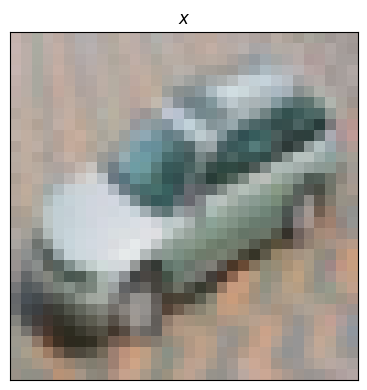

In [9]:
# load random image
id = torch.randint(0, len(dataset), (1,)).item()
print(f'Loading image {id}')
x = dataset[id][0].unsqueeze(0)
img = to_img(x)

# visualize
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.asarray(img), vmin=0, vmax=255)
ax.grid('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('$x$')

fig.tight_layout()
plt.show()

### Tests

In [10]:
def msg2str(m: torch.Tensor) -> str:
    return ''.join([('1' if el else '0') for el in m.detach().cpu().bool()])


def str2msg(m_str: str, device=None) -> torch.Tensor:
    return torch.tensor([True if el == '1' else False for el in m_str], device=device)

Image 2102 - 0
PSNR: 24.34597
Message: 101000111000010011111011110011111101010111000000
Decoded: 101000011000010111111011110011111101010111000000
Bit Accuracy: 0.95833


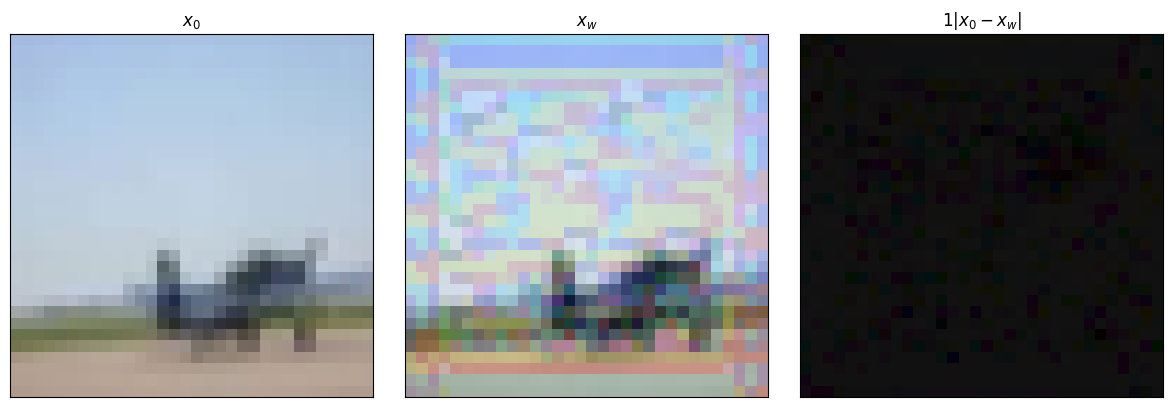

In [17]:
# load random image
id = torch.randint(0, len(dataset), (1,)).item()
x0, y = dataset[id]
x0 = x0.unsqueeze(0).to(params.device)
print(f'Image {id} - {y}')
img = to_img(x0)

# create message
random_msg = True
if random_msg:
    m_ori = torch.bernoulli(torch.full((x0.size(0), params.num_bits), 0.5, device=params.device)).bool()  # b k
else:
    m_ori = str2msg('1110101101010001', device=params.device).unsqueeze(0)
# cast to -1/1
m = 2 * m_ori.to(torch.float) - 1  # b k

# encode
x_w = encoder_with_jnd(x0, m)
# img_w = to_img(torch.round(255 * torch.clamp(DENORMALIZE_MNIST(x_w), 0, 1)) / 255)
img_w = Image.fromarray(
    DENORMALIZE_IMAGENET(x_w.squeeze(0)).squeeze().mul(255).add_(0.5).clamp_(0, 255).permute((1, 2, 0)).to('cpu', torch.uint8).numpy(),
    mode='RGB')

# psnr
psnr = peak_signal_noise_ratio(np.asarray(img), np.asarray(img_w))
print(f'PSNR: {psnr:.05f}')

# decode
m_hat = decoder(x_w)
m_decoded = m_hat > 0  # b k -> b k
print(f'Message: {msg2str(m_ori.squeeze(0))}')
print(f'Decoded: {msg2str(m_decoded.squeeze(0))}')
print(f'Bit Accuracy: {torch.eq(m_decoded, m_ori).sum().item() / params.num_bits:.05f}')

# visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()
axes[0].imshow(np.asarray(img), vmin=0, vmax=255)
axes[0].grid('off')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('$x_0$')

axes[1].imshow(np.asarray(img_w), vmin=0, vmax=255)
axes[1].grid('off')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('$x_w$')

magnitude = 1
diff_img = np.abs(np.asarray(img).astype(int) - np.asarray(img_w).astype(int)) * magnitude
diff_img = np.clip(diff_img, 0, 255).astype(np.uint8)
axes[2].imshow(diff_img, vmin=0, vmax=255)
axes[2].grid('off')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title(f'${magnitude}|x_0 - x_w|$')

fig.tight_layout()
plt.show()